In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Load the NER and POS Dataset

In [ ]:
path = '/ner_dataset.csv'

In [ ]:
data = pd.read_csv(path, encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
num_words

35179

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags

17

### Task 3: Retrieve Sentences and Corresponsing Tags

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
sentences[0], sentences[1]

([('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

### Task 4: Define Mappings between Sentences and Tags

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
word2idx;

### Task 5: Padding Input Sentences and Creating Train/Test Splits

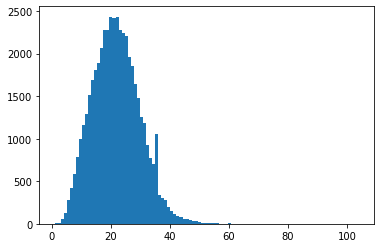

In [ ]:
plt.hist([len(s) for s in sentences], bins=100)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.wq = tf.keras.layers.Dense(self.head_dim)
        self.wk = tf.keras.layers.Dense(self.head_dim)
        self.wv = tf.keras.layers.Dense(self.head_dim)
        self.dense = tf.keras.layers.Dense(self.embed_size)


    def call(self, v, k, q, mask):
        # Get number of training examples
        batch_size = q.shape[0]

        seq_len_v, seq_len_k, seq_len_q = v.shape[1], k.shape[1], q.shape[1]


        # Split the embedding into self.heads different pieces
        v = tf.reshape(v,(batch_size,seq_len_v, self.heads, self.head_dim))
        k = tf.reshape(k,(batch_size,seq_len_k, self.heads, self.head_dim))
        q = tf.reshape(q,(batch_size,seq_len_q, self.heads, self.head_dim))


        values = self.wv(v)  # (batch_size, value_len, heads, head_dim)
        keys = self.wk(k)  # (batch_size, key_len, heads, head_dim)
        queries = self.wq(q)  # (batch_size, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example

        attention = tf.einsum("nqhd,nkhd->nhqk", queries, keys)
        # queries shape: (batch_size, seq_len_q, heads, heads_dim),
        # keys shape: (batch_size, seq_len_k, heads, heads_dim)
        # attention: (batch_size, heads, seq_len_q, seq_len_k)

         # scale matmul_qk
        dk = tf.cast(tf.shape(keys)[1], tf.float32)
        scaled_attention_logits = attention / tf.math.sqrt(dk)

        # Mask padded indices so their weights become 0

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        # attention shape: (batch_size, heads, seq_len_q, seq_len_k)



        out = tf.einsum("nhql,nlhd->nqhd", attention_weights, values)
        out = tf.reshape(out, (batch_size, seq_len_q, -1))
        # attention shape: (batch_size, heads, seq_len_q, key_len)
        # values shape: (batch_size, seq_len_v, heads, heads_dim)
        # out after matrix multiply: (batch_size, seq_len_q, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.dense(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out, attention_weights

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, embed_size, heads, forward_expansion, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.self_attens= SelfAttention(embed_size, heads)
    self.ffn = tf.keras.Sequential([
      tf.keras.layers.Dense(forward_expansion, activation='relu'),  # (batch_size, seq_len, forward_expansion)
      tf.keras.layers.Dense(embed_size)  # (batch_size, seq_len, d_model)
       ])

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.self_attens(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embed_size,  heads, forward_expansion, input_vocab_size, max_length, rate=0.1):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.num_layers = num_layers
        self.max_length = max_length
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, embed_size)

        self.Layerss =[EncoderLayer(embed_size, heads, forward_expansion, rate)
                       for _ in range(self.num_layers)]
                      

        self.dropout = tf.keras.layers.Dropout(rate)

    def positional_encoding(self):

        pos = np.arange(self.max_length)[:, np.newaxis]
        i = np.arange(self.embed_size)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(self.embed_size))

        angle_rads = pos * angle_rates

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]
                                                         
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.embed_size, tf.float32))
        x += self.positional_encoding()[:, :seq_len, :]


        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
           x = self.Layerss[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
class NER(tf.keras.Model):
    def __init__(self, num_layers, embed_size, heads, forward_expansion, input_vocab_size, target_vocab_size, max_length, rate):
        super(NER, self).__init__()
        self.encoder = Encoder(num_layers, embed_size, heads, forward_expansion,input_vocab_size, max_length, rate)
        self.decode = TimeDistributed(Dense(target_vocab_size))
    def create_masks(self, inp):
      # Encoder padding mask
        return create_padding_mask(inp)

    def call(self, x, training):
        enc_padding_mask = self.create_masks(x)
        enc_output = self.encoder(x, training, enc_padding_mask) 
        output = self.decode(enc_output)

        return output


In [ ]:
num_layers = 8
embed_size = 64
heads = 4
forward_expansion  = embed_size*4
input_vocab_size = num_words
target_vocab_size = num_tags
max_length = 1000 
rate = 0.1

In [ ]:
model=NER(num_layers, embed_size, heads, forward_expansion, input_vocab_size, target_vocab_size, max_length, rate)
outputx = model(x_train, training=False)
outputx.shape, x_train.shape

(TensorShape([38367, 50, 17]), (38367, 50))

In [ ]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 64
steps_per_epoch = x_train.shape[0]//BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)

BUFFER_SIZE_TEST = x_test.shape[0]
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(BUFFER_SIZE_TEST)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(inp, tar):
  with tf.GradientTape() as tape:
    logits = model(inp, True)
    loss = loss_object(tar, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_accuracy.update_state(tar, logits)
  return loss

In [ ]:
import time
EPOCHS = 100
history = {
  "epoch": [],
  "loss": [],
  "Accuracy" :[]
}
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  # TRAIN LOOP
  for (batch, (inp, tar)) in enumerate(dataset):
      batch_loss = train_step(inp,tar)
      total_loss = total_loss + batch_loss

  if (epoch+1) % 1 == 0: 
        history['epoch'].append(epoch)
        history['loss'].append(total_loss/(batch+1))
        history['Accuracy'].append(train_accuracy.result())
        print(f'Epoch {epoch+1}, Loss: {total_loss/(batch+1):.4f}, Accuracy: {train_accuracy.result():.4f}') 
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  train_accuracy.reset_states()

Epoch 1, Loss: 0.7004, Accuracy: 0.8537
Time taken for 1 epoch: 18.63 secs

Epoch 2, Loss: 0.3951, Accuracy: 0.9329
Time taken for 1 epoch: 11.14 secs

Epoch 3, Loss: 0.3635, Accuracy: 0.9329
Time taken for 1 epoch: 11.04 secs

Epoch 4, Loss: 0.3255, Accuracy: 0.9329
Time taken for 1 epoch: 11.18 secs

Epoch 5, Loss: 0.2838, Accuracy: 0.9344
Time taken for 1 epoch: 11.03 secs

Epoch 6, Loss: 0.2526, Accuracy: 0.9371
Time taken for 1 epoch: 11.20 secs

Epoch 7, Loss: 0.2336, Accuracy: 0.9394
Time taken for 1 epoch: 11.12 secs

Epoch 8, Loss: 0.2192, Accuracy: 0.9418
Time taken for 1 epoch: 11.16 secs

Epoch 9, Loss: 0.2070, Accuracy: 0.9442
Time taken for 1 epoch: 11.14 secs

Epoch 10, Loss: 0.1940, Accuracy: 0.9476
Time taken for 1 epoch: 11.15 secs

Epoch 11, Loss: 0.1823, Accuracy: 0.9510
Time taken for 1 epoch: 11.24 secs

Epoch 12, Loss: 0.1711, Accuracy: 0.9537
Time taken for 1 epoch: 11.17 secs

Epoch 13, Loss: 0.1621, Accuracy: 0.9561
Time taken for 1 epoch: 11.18 secs

Epoch 14

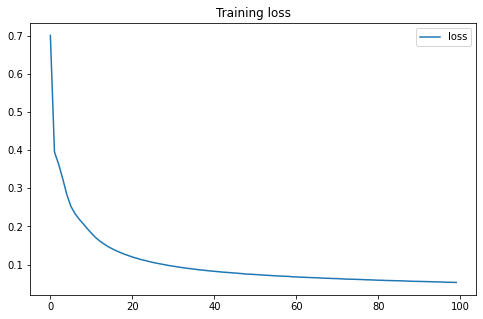

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history["epoch"],history["loss"], label='loss')
plt.title('Training loss')
plt.legend(loc='best')
plt.show()

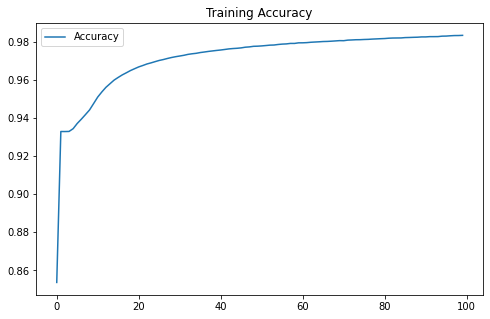

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history["epoch"],history["Accuracy"], label='Accuracy')
plt.title('Training Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
def evaluate(inp):
    logits = model(inp, False)
    predicted_id = tf.argmax(logits, axis=-1)
    return logits, predicted_id

In [ ]:
start = time.time()
for (batch, (inp, tar)) in enumerate(dataset_test):
    logits,_ = evaluate(inp)
    test_accuracy.update_state(tar, logits)
print('Accuracy of model on Test : ', test_accuracy.result().numpy())
print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Accuracy of model on Test :  0.9787594
Time taken for 1 epoch: 11.27 secs



In [ ]:
def evaluate(inp):
    logits = model(inp, False)
    predicted_id = tf.argmax(logits, axis=-1)
    return logits, predicted_id
for (batch, (inp, tar)) in enumerate(dataset_test.take(1)):
    x_test = inp
    y_test = tar
    _,prob = evaluate(inp)

In [ ]:
i = np.random.randint(0, x_test.shape[0]) #659
p = prob[i]
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))
    if w == 35178:
      break

Word           True 	 Pred

------------------------------
In             O	O
late           O	O
March          B-tim	B-tim
,              O	O
at             O	O
least          O	O
42             O	O
people         O	O
were           O	O
killed         O	O
in             O	O
twin           O	O
bombings       O	O
near           O	O
a              O	O
restaurant     O	O
in             O	O
Khalis         B-org	B-org
.              O	O
Chiao          O	O
